<a href="https://colab.research.google.com/github/amansurkar/Deep-Learning/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plot-utils

     |████████████████████████████████| 13.3MB 236kB/s 


In [0]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

In [0]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images)-1) // n_cols + 1
    if images.shape[-1]== 1:
        images=np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap='binary')   
        plt.axis('off') 


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

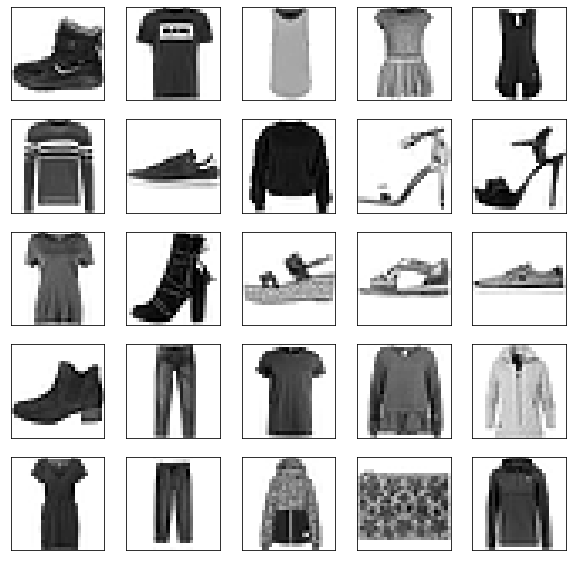

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()  

In [0]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset=dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
num_features=100
generator = keras.models.Sequential([
                                     keras.layers.Dense(7*7*128, input_shape=[num_features]),
                                     keras.layers.Reshape([7,7,128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')


])

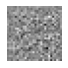

In [9]:
noise=tf.random.normal(shape=[1, num_features])
generated_image=generator(noise, training=False)
show(generated_image, 1)

In [0]:
discriminator = keras.models.Sequential([
                                         keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28,28,1]),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation='sigmoid')
                                    
]) 

In [11]:
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.4984969]], shape=(1, 1), dtype=float32)


In [0]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan=keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [0]:
seed=tf.random.normal(shape=[batch_size, 100])

In [0]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print('Epochs {}/{}'.format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images=generator(noise)
            X_fake_and_real=tf.concat([generated_images, X_batch], axis=0)
            y1=tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
            discriminator.trainable=True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2=tf.constant([[1.]]*batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.

In [0]:
batch_size=32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


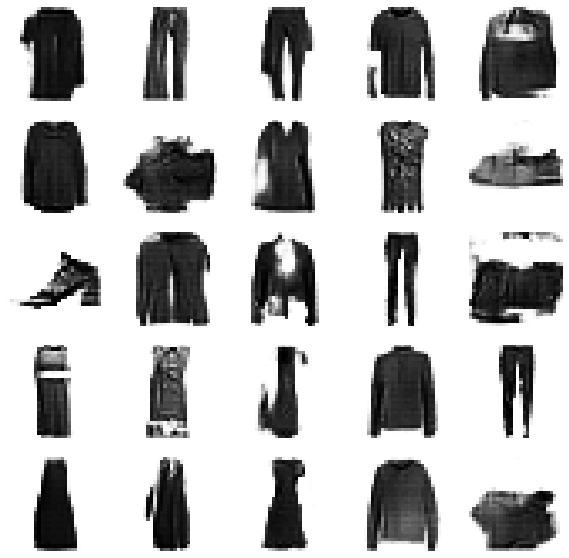

CPU times: user 36min 34s, sys: 2min 10s, total: 38min 45s
Wall time: 43min 47s


In [21]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=70)

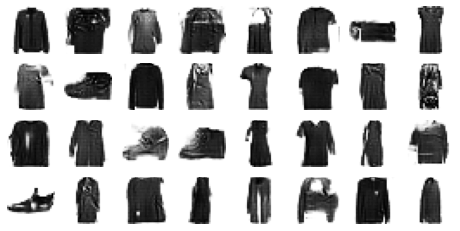

In [22]:
noise=tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

In [0]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [38]:
gan.save('gan.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gan.model/assets
